# H&M Fashion Recommender

## Cấu hình chung

In [ ]:
import os, gc, csv, math, time
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OneHotEncoder, StandardScaler, normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# Kaggle paths
DATA_DIR = Path("/kaggle/input/h-and-m-personalized-fashion-recommendations")
ARTIFACT_DIR = Path("/kaggle/working/artifacts")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

print("DATA_DIR:", DATA_DIR, "| Exists:", DATA_DIR.exists())
print("ARTIFACT_DIR:", ARTIFACT_DIR)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

In [ ]:
SAMPLE_PATH = DATA_DIR / "sample_submission.csv"
sample_sub = pd.read_csv(SAMPLE_PATH)

sample_customer_ids = sample_sub["customer_id"].astype(str).tolist()
print("sample_submission rows:", len(sample_customer_ids))
print("example customer:", sample_customer_ids[0])

# map prediction 
sample_pred_map = dict(zip(
    sample_sub["customer_id"].astype(str).values,
    sample_sub["prediction"].astype(str).values
))

## Hàm phụ trợ 

In [ ]:
IMG_DIR = DATA_DIR / "images"

def pad_article_id(aid) -> str:
    """Kaggle submission dùng 10-digit article_id."""
    try:
        return str(int(aid)).zfill(10)
    except Exception:
        s = str(aid)
        return s.zfill(10) if s.isdigit() else s

def uniq_keep_order(xs):
    seen = set()
    out = []
    for x in xs:
        if x not in seen:
            out.append(x)
            seen.add(x)
    return out

def ensure_12(recs, fallback_12):
    recs = [pad_article_id(x) for x in recs]
    recs = uniq_keep_order(recs)
    if len(recs) < 12:
        recs = recs + [pad_article_id(x) for x in fallback_12]
        recs = uniq_keep_order(recs)
    return recs[:12]

def write_submission_stream(customer_ids, rec_fn, fallback_12, out_csv, max_customers=None):
    """
    Ghi submission dạng stream (không giữ DataFrame lớn).
    rec_fn(cid) -> list article_id
    """
    out_csv = str(out_csv)
    n = len(customer_ids) if max_customers is None else min(len(customer_ids), max_customers)

    with open(out_csv, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["customer_id", "prediction"])
        for cid in tqdm(customer_ids[:n], total=n, desc=f"Write {Path(out_csv).name}"):
            recs = rec_fn(cid)
            recs12 = ensure_12(recs, fallback_12)
            w.writerow([cid, " ".join(recs12)])

    print("Saved:", out_csv, "| rows:", n)

def get_image_path(article_id):
    aid_str = pad_article_id(article_id)
    subdir = aid_str[:3]
    return IMG_DIR / subdir / f"{aid_str}.jpg"

def _plot_article_row(article_ids, axes_row, fontsize=8):
    n_cols = len(axes_row)
    for col_idx, ax in enumerate(axes_row):
        if col_idx < len(article_ids):
            aid = article_ids[col_idx]
            try:
                img = Image.open(get_image_path(aid))
                ax.imshow(img)
            except Exception:
                ax.text(0.5, 0.5, str(aid), ha="center", va="center")
            ax.set_title(str(aid), fontsize=fontsize)
        else:
            ax.set_title("")
        ax.axis("off")

In [ ]:
def _to_int_list_from_pred_str(pred_str: str):
    # sample_submission prediction là chuỗi 12 ids cách nhau bởi space
    toks = str(pred_str).strip().split()
    out = []
    for t in toks:
        t = t.strip()
        if not t:
            continue
        # "0706016001" -> int
        try:
            out.append(int(t))
        except Exception:
            pass
    return out

def ap_at_12(true_items, pred_items):
    """
    AP@12 theo công thức:
    AP@12 = 1/min(m,12) * sum_{k=1..min(n,12)} P(k)*rel(k)
    """
    if true_items is None or len(true_items) == 0:
        return None  # không đánh giá được

    true_set = set(map(int, true_items))
    pred = [int(x) for x in pred_items[:12]]

    hit = 0
    s = 0.0
    for k, aid in enumerate(pred, start=1):
        if aid in true_set:
            hit += 1
            s += hit / k
    denom = min(len(true_set), 12)
    return s / denom if denom > 0 else None

def map_at_12_on_customers(customer_ids, true_dict, rec_fn, max_users=None):
    """
    Đánh giá MAP@12 trên đúng list customer_ids (ví dụ từ sample_submission).
    - Chỉ tính trên users có ground truth (có mua trong test week nội bộ).
    """
    cids = list(map(str, customer_ids))
    if max_users is not None:
        cids = cids[:max_users]

    total = 0.0
    cnt = 0
    skipped_no_gt = 0

    for cid in tqdm(cids, desc="Eval MAP@12"):
        gt = true_dict.get(cid, [])
        if not gt:
            skipped_no_gt += 1
            continue

        pred = rec_fn(cid)
        # pred có thể là list int (từ recommend_*) hoặc list str -> ép int
        pred_int = []
        for x in pred[:12]:
            try:
                pred_int.append(int(x))
            except Exception:
                pass

        ap = ap_at_12(gt, pred_int)
        if ap is None:
            skipped_no_gt += 1
            continue
        total += ap
        cnt += 1

    return {
        "MAP@12": total / max(1, cnt),
        "eval_users": cnt,
        "skipped_no_gt": skipped_no_gt
    }

def map_at_12_from_sample_submission(customer_ids, true_dict, sample_pred_map, max_users=None):
    """MAP@12 nếu dùng prediction có sẵn trong sample_submission.csv (để so sánh baseline)."""
    cids = list(map(str, customer_ids))
    if max_users is not None:
        cids = cids[:max_users]

    total = 0.0
    cnt = 0
    skipped_no_gt = 0

    for cid in tqdm(cids, desc="Eval MAP@12 (sample_submission pred)"):
        gt = true_dict.get(cid, [])
        if not gt:
            skipped_no_gt += 1
            continue
        pred_str = sample_pred_map.get(cid, "")
        pred = _to_int_list_from_pred_str(pred_str)
        ap = ap_at_12(gt, pred)
        if ap is None:
            skipped_no_gt += 1
            continue
        total += ap
        cnt += 1

    return {
        "MAP@12": total / max(1, cnt),
        "eval_users": cnt,
        "skipped_no_gt": skipped_no_gt
    }

## Chuẩn bị dữ liệu 

In [ ]:
articles = pd.read_csv(DATA_DIR / "articles.csv")
customers = pd.read_csv(DATA_DIR / "customers.csv")
transactions = pd.read_csv(DATA_DIR / "transactions_train.csv", parse_dates=["t_dat"])

print("articles:", articles.shape)
print("customers:", customers.shape)
print("transactions:", transactions.shape)

max_date = transactions["t_dat"].max()
test_start = max_date - pd.Timedelta(weeks=1)
train_start = test_start - pd.Timedelta(weeks=6)

train_df = transactions[(transactions["t_dat"] >= train_start) & (transactions["t_dat"] < test_start)].copy()
test_df  = transactions[transactions["t_dat"] >= test_start].copy()

print("Max date      :", max_date)
print("Train from    :", train_start, "->", test_start)
print("Test from     :", test_start, "->", max_date)
print("Train shape   :", train_df.shape)
print("Test shape    :", test_df.shape)

# Ground truth trong tuần test nội bộ
true_items_dict = test_df.groupby("customer_id")["article_id"].apply(list).to_dict()
print("test users:", len(true_items_dict))

all_customer_ids = customers["customer_id"].astype(str).values

## EDA

In [ ]:
# Age buckets
cust_basic = customers[["customer_id", "age"]].copy()
cust_basic["age_bucket"] = pd.cut(
    cust_basic["age"],
    bins=[0, 18, 25, 35, 50, 100],
    labels=["<18", "18-25", "25-35", "35-50", "50+"]
)

plt.figure(figsize=(6,4))
cust_basic["age_bucket"].value_counts().sort_index().plot(kind="bar")
plt.title("Phân bố nhóm tuổi khách hàng")
plt.xlabel("Nhóm tuổi"); plt.ylabel("Số khách hàng")
plt.tight_layout(); plt.show()

# Top product type
plt.figure(figsize=(10,4))
articles["product_type_name"].value_counts().head(15).plot(kind="bar")
plt.title("Top 15 Product Type phổ biến")
plt.xticks(rotation=60, ha="right")
plt.tight_layout(); plt.show()

# Transactions per day
tmp = train_df.copy()
tmp["date"] = tmp["t_dat"].dt.date
tx_per_day = tmp.groupby("date")["t_dat"].count()

plt.figure(figsize=(10,4))
tx_per_day.plot()
plt.title("Số giao dịch mỗi ngày (6 tuần train)")
plt.xticks(rotation=45)
plt.tight_layout(); plt.show()


## Popularity Recommender

In [ ]:
from pathlib import Path
from tqdm.auto import tqdm
import numpy as np

# =========================
# Popularity — build
# =========================
def get_global_popular_items(train_df, topk=5000):
    item_pop = train_df.groupby("article_id")["t_dat"].count().sort_values(ascending=False)
    popular_items = item_pop.head(topk).index.astype(int).tolist()
    return popular_items, item_pop

popular_items, item_pop_series = get_global_popular_items(train_df, topk=5000)
popular_12 = popular_items[:12]
print("Top 12 popular:", popular_12)

def rec_popularity(cid):
    return popular_12  # list int

# =========================
# Submission 
# =========================
OUT_POP = Path("/kaggle/working/submission_popularity_SAMPLE.csv")
write_submission_stream(
    sample_customer_ids,
    rec_popularity,
    fallback_12=popular_12,
    out_csv=OUT_POP,
    max_customers=None
)
print("Saved:", OUT_POP)

# =========================
# Metrics @12: MAP, Precision, Recall, F1, Accuracy (subset), Hit@12
# =========================
def ap_at_12(true_items, pred_items):
    if not true_items:
        return None
    true_set = set(map(int, true_items))
    pred = [int(x) for x in pred_items[:12]]

    hit = 0
    s = 0.0
    for k, aid in enumerate(pred, start=1):
        if aid in true_set:
            hit += 1
            s += hit / k
    denom = min(len(true_set), 12)
    return s / denom if denom > 0 else None

def eval_metrics_at_12(customer_ids, true_dict, rec_fn, max_users=20000):
    cids = list(map(str, customer_ids))
    if max_users is not None:
        cids = cids[:max_users]

    # MAP
    map_sum = 0.0
    map_cnt = 0

    # Micro totals for P/R/F1
    TP = 0
    FP = 0
    FN = 0

    # Accuracy (subset) + Hit@12
    subset_acc_sum = 0
    hit_sum = 0

    skipped_no_gt = 0

    for cid in tqdm(cids, desc="Eval @12 (MAP/P/R/F1/Acc)"):
        gt = true_dict.get(cid, [])
        if not gt:
            skipped_no_gt += 1
            continue

        gt_set = set(map(int, gt))
        pred = rec_fn(cid)[:12]

        pred_int = []
        for x in pred:
            try:
                pred_int.append(int(x))
            except Exception:
                pass
        pred_int = pred_int[:12]
        pred_set = set(pred_int)

        # AP / MAP
        ap = ap_at_12(gt, pred_int)
        if ap is not None:
            map_sum += ap
            map_cnt += 1

        # Confusion counts (treat set-based @12)
        tp = len(gt_set & pred_set)
        fp = len(pred_set - gt_set)
        fn = len(gt_set - pred_set)

        TP += tp
        FP += fp
        FN += fn

        # Hit@12 (any correct)
        if tp > 0:
            hit_sum += 1

        # Subset accuracy: tất cả GT (giới hạn 12) nằm trong dự đoán
        gt_cap = set(list(gt_set)[:12])  # cap cho đúng tinh thần @12
        subset_acc_sum += 1 if gt_cap.issubset(pred_set) else 0

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1        = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0

    eval_users = (len(cids) - skipped_no_gt)
    map12 = map_sum / max(1, map_cnt)

    return {
        "MAP@12": map12,
        "Precision@12_micro": precision,
        "Recall@12_micro": recall,
        "F1@12_micro": f1,
        "Accuracy_subset@12": subset_acc_sum / max(1, eval_users),
        "Hit@12_any": hit_sum / max(1, eval_users),
        "eval_users": eval_users,
        "skipped_no_gt": skipped_no_gt
    }

# =========================
# RUN EVAL
# =========================
MAX_EVAL_USERS = 20000  
metrics_pop = eval_metrics_at_12(sample_customer_ids, true_items_dict, rec_popularity, max_users=MAX_EVAL_USERS)
print("Popularity metrics (internal, sample customers):")
for k, v in metrics_pop.items():
    print(f"  {k}: {v}")


## Lấy tập mẫu 

### Phân tầng người dùng 

In [ ]:
user_tx_counts = (
    transactions.groupby("customer_id")["article_id"]
    .count()
    .reset_index(name="n_transactions")
)

def assign_segment(n_tx: int) -> str:
    if n_tx <= 20:  return "new_users"
    if n_tx <= 100: return "medium_users"
    if n_tx <= 200: return "frequent_users"
    if n_tx <= 500: return "heavy_users"
    return "super_users"

segment_order = ["new_users","medium_users","frequent_users","heavy_users","super_users"]
user_tx_counts["user_segment"] = user_tx_counts["n_transactions"].apply(assign_segment)

seg_counts = user_tx_counts["user_segment"].value_counts().reindex(segment_order).fillna(0).astype(int)
plt.figure(figsize=(8,5))
seg_counts.plot(kind="bar")
plt.title("Phân bố phân tầng người dùng (toàn bộ dữ liệu)")
plt.xlabel("Phân tầng"); plt.ylabel("Số khách hàng")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()

### Lấy tập mẫu dựa trên phân tầng 

In [ ]:
# Sample users per segment
N_PER_SEGMENT = 1000
sampled_user_ids = []
for seg in segment_order:
    seg_users = user_tx_counts.loc[user_tx_counts["user_segment"] == seg, "customer_id"]
    if len(seg_users) == 0:
        continue
    n_pick = min(N_PER_SEGMENT, len(seg_users))
    sampled_user_ids.append(seg_users.sample(n_pick, random_state=RANDOM_STATE))
sampled_user_ids = pd.concat(sampled_user_ids).astype(str).values
print("Sampled users:", len(sampled_user_ids))

# Lấy giao dịch (TRONG 6 tuần train) của user sampled
train_seg = train_df.merge(user_tx_counts[["customer_id","user_segment"]], on="customer_id", how="left")
sampled_tx = train_seg[train_seg["customer_id"].astype(str).isin(sampled_user_ids)].copy()

print("sampled_tx:", sampled_tx.shape, "| unique users:", sampled_tx["customer_id"].nunique(), "| unique items:", sampled_tx["article_id"].nunique())

## Collaborative Filtering dùng SVD

In [ ]:
from scipy.sparse import coo_matrix

ui_df = sampled_tx[["customer_id","article_id"]].drop_duplicates()
user_ids = ui_df["customer_id"].astype(str).unique()
item_ids = ui_df["article_id"].astype(int).unique()

user_id_to_idx = {u:i for i,u in enumerate(user_ids)}
item_id_to_idx = {a:j for j,a in enumerate(item_ids)}
idx_to_item_id = {j:a for a,j in item_id_to_idx.items()}

rows = ui_df["customer_id"].astype(str).map(user_id_to_idx).values
cols = ui_df["article_id"].astype(int).map(item_id_to_idx).values
data = np.ones(len(ui_df), dtype=np.float32)

UI = coo_matrix((data, (rows, cols)), shape=(len(user_ids), len(item_ids))).tocsr()
print("UI shape:", UI.shape)

K_FACTORS = 64
svd = TruncatedSVD(n_components=K_FACTORS, random_state=RANDOM_STATE)
U = svd.fit_transform(UI)        # (n_users, K) ~ UI * V^T  (đã "ăn" Sigma)
Vt = svd.components_             # (K, n_items)

# map user -> bought items set (trong sampled_tx)
user_to_items_sample = ui_df.groupby("customer_id")["article_id"].apply(set).to_dict()

def recommend_cf_svd(customer_id, topk=10):
    customer_id = str(customer_id)
    if customer_id not in user_id_to_idx:
        return []

    u_idx = user_id_to_idx[customer_id]
    # scores = U[u] @ Vt  (không tạo R_hat)
    scores = U[u_idx].dot(Vt)  # (n_items,)
    bought = user_to_items_sample.get(customer_id, set())

    # lấy top (topk + buffer) để lọc item đã mua
    buf = max(200, topk * 50)
    top_idx = np.argpartition(-scores, kth=min(buf, len(scores)-1))[:buf]
    top_idx = top_idx[np.argsort(-scores[top_idx])]

    recs = []
    for j in top_idx:
        aid = int(idx_to_item_id[int(j)])
        if aid not in bought:
            recs.append(aid)
        if len(recs) >= topk:
            break
    return recs

In [ ]:
def show_cf_svd_visual(customer_id, topk=8):
    true_items = true_items_dict.get(customer_id, [])[:topk]
    if len(true_items) == 0:
        print(f"[CF–SVD] User {customer_id} không có giao dịch trong tuần test.")
        return

    pred_items = recommend_cf_svd(customer_id, topk=topk)

    print(f"User: {customer_id}")
    print("  True (test week):", true_items)
    print("  CF–SVD recs     :", pred_items)

    n_cols = max(len(true_items), len(pred_items))
    if n_cols == 0:
        return

    fig, axes = plt.subplots(2, n_cols, figsize=(2.2*n_cols, 6))
    axes = np.array(axes)
    if axes.ndim == 1:
        axes = axes.reshape(2, n_cols)

    _plot_article_row(true_items, axes[0, :], fontsize=9)
    _plot_article_row(pred_items, axes[1, :], fontsize=9)

    fig.text(0.5, 0.94, "CF–SVD — MA TRẬN TƯƠNG TÁC USER–ITEM + TRUNCATED SVD",
             ha="center", va="center", fontsize=14, fontweight="bold")
    fig.text(0.02, 0.70, "Thực tế", rotation=90, ha="center", va="center", fontsize=11, fontweight="bold")
    fig.text(0.02, 0.25, "Gợi ý",   rotation=90, ha="center", va="center", fontsize=11, fontweight="bold")
    plt.tight_layout(rect=[0.05, 0.02, 1.0, 0.92])
    plt.show()

# demo
candidate_users = [cid for cid in ui_df["customer_id"].astype(str).unique() if cid in true_items_dict]
demo_users = pd.Series(candidate_users).sample(min(3, len(candidate_users)), random_state=RANDOM_STATE).tolist()
for cid in demo_users:
    print("="*80)
    show_cf_svd_visual(cid, topk=12)

In [ ]:
import csv
from pathlib import Path
from tqdm.auto import tqdm

# =========================
# CF-SVD — rec function
# =========================
def rec_cf_svd(cid):
    return recommend_cf_svd(str(cid), topk=12)  # list int

# =========================
# SUBMISSION (SAMPLE ONLY)
# =========================
OUT_CF = Path("/kaggle/working/submission_cf_svd_SAMPLE.csv")
write_submission_stream(
    sample_customer_ids,
    rec_cf_svd,
    fallback_12=popular_12,
    out_csv=OUT_CF,
    max_customers=None
)
print("Saved:", OUT_CF)

# =========================
# EVAL: MAP@12 + Precision/Recall/F1/Accuracy/Hit@12
# =========================
MAX_EVAL_USERS = 20000  # None nếu muốn full sample

metrics_cf = eval_metrics_at_12(
    sample_customer_ids,
    true_items_dict,
    rec_cf_svd,
    max_users=MAX_EVAL_USERS
)

print("CF-SVD metrics (internal, sample customers):")
for k, v in metrics_cf.items():
    print(f"  {k}: {v}")


## Content-based (User & Item Feature Matrix)

In [ ]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.neighbors import NearestNeighbors

from scipy.sparse import csr_matrix, hstack, coo_matrix, diags

try:
    from gensim.models import Word2Vec
    from gensim.utils import simple_preprocess
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "gensim"])
    from gensim.models import Word2Vec
    from gensim.utils import simple_preprocess

try:
    from sklearn.preprocessing import OneHotEncoder
    _ = OneHotEncoder(sparse_output=True)
    def make_ohe():
        return OneHotEncoder(handle_unknown="ignore", sparse_output=True)
except TypeError:
    from sklearn.preprocessing import OneHotEncoder
    def make_ohe():
        return OneHotEncoder(handle_unknown="ignore", sparse=True)

In [ ]:
# -------------------------
# 0) Chuẩn hoá article_id
# -------------------------
transactions = transactions.copy()
articles = articles.copy()
train_df = train_df.copy()

transactions["article_id"] = transactions["article_id"].astype(int)
articles["article_id"] = articles["article_id"].astype(int)
train_df["article_id"] = train_df["article_id"].astype(int)
train_df["customer_id"] = train_df["customer_id"].astype(str)


In [ ]:
# -------------------------
# 1) Giá trung bình mỗi article
# -------------------------
article_price = (
    transactions.groupby("article_id")["price"]
    .mean()
    .reset_index(name="price")
)


In [ ]:
# -------------------------
# 2) Item meta (TOÀN BỘ articles)
# -------------------------
cat_cols = ["product_type_name","product_group_name","graphical_appearance_name","colour_group_name"]

item_meta = articles[[
    "article_id",
    "product_type_name",
    "product_group_name",
    "graphical_appearance_name",
    "colour_group_name",
    "detail_desc",
]].copy()

item_meta = item_meta.merge(article_price, on="article_id", how="left")

# fill missing
item_meta["price"] = item_meta["price"].fillna(item_meta["price"].median())

for c in cat_cols:
    item_meta[c] = item_meta[c].fillna("UNK").astype(str)

item_meta["detail_desc"] = item_meta["detail_desc"].fillna("").astype(str).str.lower()

# sort để mapping ổn định
item_meta = item_meta.sort_values("article_id").reset_index(drop=True)

In [ ]:
# -------------------------
# 3) Train/Load Word2Vec (cache)
# -------------------------
W2V_DIM = 100
w2v_path = Path(ARTIFACT_DIR) / f"w2v_dim{W2V_DIM}.model"

# tokenize tốt hơn split() (lọc punctuation, số, ký tự lạ)
tokenized = [simple_preprocess(s) for s in item_meta["detail_desc"].values]
sentences = [toks for toks in tokenized if len(toks) > 0]
print("Word2Vec sentences:", len(sentences))

if len(sentences) == 0:
    print("[WARN] Không có mô tả detail_desc để train W2V -> sẽ dùng vector 0.")
    w2v_model = None
else:
    if w2v_path.exists():
        w2v_model = Word2Vec.load(str(w2v_path))
        print("Loaded:", w2v_path)
    else:
        w2v_model = Word2Vec(
            sentences=sentences,
            vector_size=W2V_DIM,
            window=5,
            min_count=2,
            workers=4,
            sg=1,                 # skip-gram
            seed=RANDOM_STATE,
        )
        w2v_model.save(str(w2v_path))
        print("Saved:", w2v_path)

def get_w2v_vector_from_tokens(toks) -> np.ndarray:
    if w2v_model is None or toks is None or len(toks) == 0:
        return np.zeros(W2V_DIM, dtype=np.float32)
    vecs = [w2v_model.wv[w] for w in toks if w in w2v_model.wv]
    if not vecs:
        return np.zeros(W2V_DIM, dtype=np.float32)
    return np.mean(vecs, axis=0).astype(np.float32)

In [ ]:
# -------------------------
# 4) Build item feature matrix (sparse)
# -------------------------
ohe = make_ohe()
X_cat = ohe.fit_transform(item_meta[cat_cols])  # sparse

# num price -> scale (dense n×1) rồi đưa về sparse
scaler = StandardScaler()
X_num = scaler.fit_transform(item_meta[["price"]].values).astype(np.float32)  # dense (n,1)

# W2V matrix (dense n×W2V_DIM)
w2v_mat = np.vstack([
    get_w2v_vector_from_tokens(toks)
    for toks in tqdm(tokenized, desc="W2V vec")
]).astype(np.float32)

X_item = hstack([X_cat, csr_matrix(X_num), csr_matrix(w2v_mat)], format="csr")

# normalize để cosine similarity = dot product
X_item_norm = normalize(X_item, norm="l2", axis=1)

item_ids_all = item_meta["article_id"].astype(int).values
aid2row_cb = {int(a): i for i, a in enumerate(item_ids_all)}
row2aid_cb = {i: int(a) for i, a in enumerate(item_ids_all)}

print("X_item shape:", X_item.shape, "| nnz:", X_item.nnz)

In [ ]:
# -------------------------
# 5) item-item KNN (similar items)
# -------------------------
knn_item_cb = NearestNeighbors(n_neighbors=200, metric="cosine", algorithm="brute")
knn_item_cb.fit(X_item_norm)
print("KNN item (CB) fitted.")

def get_similar_items(article_id, topk=10):
    a = int(article_id)
    r = aid2row_cb.get(a, None)
    if r is None:
        return []
    # kneighbors trả về distance cosine (0 tốt nhất)
    dist, neigh = knn_item_cb.kneighbors(X_item_norm[r], n_neighbors=min(topk+1, len(item_ids_all)))
    neigh = neigh.ravel().tolist()

    out = []
    for rr in neigh:
        aa = row2aid_cb[int(rr)]
        if aa != a:
            out.append(aa)
        if len(out) >= topk:
            break
    return out


In [ ]:
# -------------------------
# 6) User profile = mean(item features đã mua) (sparse UI)
# -------------------------
ui_train = train_df[["customer_id","article_id"]].drop_duplicates().copy()
ui_train["customer_id"] = ui_train["customer_id"].astype(str)
ui_train["article_id"] = ui_train["article_id"].astype(int)

# chỉ giữ items có trong item_meta
ui_train = ui_train[ui_train["article_id"].isin(aid2row_cb)].reset_index(drop=True)

u_ids = ui_train["customer_id"].unique()
u2idx = {u:i for i,u in enumerate(u_ids)}
cid2urow_cb = {u:i for i,u in enumerate(u_ids)}

rows = ui_train["customer_id"].map(u2idx).values
cols = ui_train["article_id"].map(aid2row_cb).values
data = np.ones(len(ui_train), dtype=np.float32)

UI_train_cb = coo_matrix((data, (rows, cols)), shape=(len(u_ids), len(item_ids_all))).tocsr()

cnt = np.asarray(UI_train_cb.sum(axis=1)).ravel().astype(np.float32)
cnt[cnt == 0] = 1.0
Dinv = diags(1.0 / cnt)

# mean of purchased item vectors
user_profile_cb = Dinv.dot(UI_train_cb).dot(X_item_norm)  # (n_users, d) sparse

# normalize user profile để cosine ổn định
user_profile_cb = normalize(user_profile_cb, norm="l2", axis=1)

# map user -> bought set (train)
user_to_items_train = ui_train.groupby("customer_id")["article_id"].apply(set).to_dict()

def recommend_content_based(customer_id, topk=10, buf_mul=80):
    customer_id = str(customer_id)
    urow = cid2urow_cb.get(customer_id, None)
    if urow is None:
        return []

    uvec = user_profile_cb[urow]  # (1,d) sparse
    # cosine similarity = dot(uvec, X_item_norm.T)
    sims = uvec.dot(X_item_norm.T).toarray().ravel()  # (n_items,)

    bought = user_to_items_train.get(customer_id, set())

    n = len(sims)
    if n == 0:
        return []

    buf = min(n, max(500, topk * buf_mul))
    kth = min(n - 1, buf - 1)

    top_idx = np.argpartition(-sims, kth=kth)[:buf]
    top_idx = top_idx[np.argsort(-sims[top_idx])]

    recs = []
    for r in top_idx:
        aid = row2aid_cb[int(r)]
        if aid not in bought:
            recs.append(aid)
        if len(recs) >= topk:
            break
    return recs


In [ ]:
# -------------------------
# 7) Visual demo 
# -------------------------
def show_cb_visual(customer_id, topk=8):
    customer_id = str(customer_id)
    true_items = true_items_dict.get(customer_id, [])[:topk]
    if len(true_items) == 0:
        print(f"[Content-based] User {customer_id} không có giao dịch trong tuần test.")
        return

    pred_items = recommend_content_based(customer_id, topk=topk)

    print(f"User: {customer_id}")
    print("  True (test week):", true_items)
    print("  CB recs         :", pred_items)

    if "_plot_article_row" not in globals():
        print("[WARN] Chưa có hàm _plot_article_row -> bỏ qua phần vẽ ảnh.")
        return

    import matplotlib.pyplot as plt

    n_cols = max(len(true_items), len(pred_items))
    if n_cols == 0:
        return

    fig, axes = plt.subplots(2, n_cols, figsize=(2.2*n_cols, 6))
    axes = np.array(axes)
    if axes.ndim == 1:
        axes = axes.reshape(2, n_cols)

    _plot_article_row(true_items, axes[0, :], fontsize=9)
    _plot_article_row(pred_items, axes[1, :], fontsize=9)

    fig.text(0.5, 0.94, "CONTENT-BASED — USER PROFILE (MEAN ITEM FEATURES) + COSINE",
             ha="center", va="center", fontsize=14, fontweight="bold")
    fig.text(0.02, 0.70, "Thực tế", rotation=90, ha="center", va="center", fontsize=11, fontweight="bold")
    fig.text(0.02, 0.25, "Gợi ý",   rotation=90, ha="center", va="center", fontsize=11, fontweight="bold")
    plt.tight_layout(rect=[0.05, 0.02, 1.0, 0.92])
    plt.show()

# demo vài users có test ground-truth
candidate_users = [cid for cid in train_df["customer_id"].unique() if cid in true_items_dict]
if len(candidate_users) > 0:
    demo_users = pd.Series(candidate_users).sample(min(3, len(candidate_users)), random_state=RANDOM_STATE).tolist()
    for cid in demo_users:
        print("="*80)
        show_cb_visual(cid, topk=12)
else:
    print("[INFO] Không tìm thấy user nào có true_items_dict để demo.")

In [ ]:
from pathlib import Path

# =========================
# Content-based — rec function
# =========================
def rec_cb(cid):
    return recommend_content_based(str(cid), topk=12)  # list int (có thể <12)

# =========================
# SUBMISSION (SAMPLE ONLY)
# =========================
OUT_CB = Path("/kaggle/working/submission_cb_SAMPLE.csv")
write_submission_stream(
    sample_customer_ids,
    rec_cb,
    fallback_12=popular_12,
    out_csv=OUT_CB,
    max_customers=10000 
)
print("Saved:", OUT_CB)

# =========================
# EVAL: MAP@12 + Precision/Recall/F1/Accuracy/Hit@12
# =========================
MAX_EVAL_USERS = 20000  # None nếu muốn eval full sample

metrics_cb = eval_metrics_at_12(
    sample_customer_ids,
    true_items_dict,
    rec_cb,
    max_users=MAX_EVAL_USERS
)

print("CB metrics (internal, sample customers):")
for k, v in metrics_cb.items():
    print(f"  {k}: {v}")


## Image-based + KNN — ResNet50 / ViT Base / DINO Base (ITEM-BASED)

In [ ]:
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from sklearn.neighbors import NearestNeighbors

# install timm if needed (for ViT / DINO)
try:
    import timm
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "timm"])
    import timm

img_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

def load_image_tensor(article_id):
    p = get_image_path(article_id)
    if not p.exists():
        return None
    try:
        im = Image.open(p).convert("RGB")
        return img_tf(im)
    except Exception:
        return None

@torch.no_grad()
def build_img_embeddings(article_ids, model, batch_size=128):
    model.eval()
    kept_ids, embs = [], []
    batch_imgs, batch_ids = [], []

    for aid in tqdm(article_ids, desc="IMG embed"):
        t = load_image_tensor(aid)
        if t is None:
            continue
        batch_imgs.append(t)
        batch_ids.append(int(aid))
        if len(batch_imgs) >= batch_size:
            x = torch.stack(batch_imgs).to(device)
            z = model(x)
            z = torch.nn.functional.normalize(z, dim=1)
            embs.append(z.detach().cpu())
            kept_ids.extend(batch_ids)
            batch_imgs, batch_ids = [], []

    if len(batch_imgs) > 0:
        x = torch.stack(batch_imgs).to(device)
        z = model(x)
        z = torch.nn.functional.normalize(z, dim=1)
        embs.append(z.detach().cpu())
        kept_ids.extend(batch_ids)

    embs = torch.cat(embs, dim=0).numpy().astype(np.float16)
    kept_ids = np.array(kept_ids, dtype=np.int32)
    return kept_ids, embs

# ---- models
def get_resnet50_embedder():
    from torchvision.models import resnet50, ResNet50_Weights
    m = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    m.fc = torch.nn.Identity()
    return m.to(device)

def get_timm_embedder(name):
    # num_classes=0 => returns pooled features for most timm models
    m = timm.create_model(name, pretrained=True, num_classes=0)
    return m.to(device)

# ---- choose items with images (top popular)
MAX_IMG_ITEMS = 30000
candidate_img_items = item_pop_series.index.astype(int).tolist()[:MAX_IMG_ITEMS] if "item_pop_series" in globals() else articles["article_id"].astype(int).tolist()[:MAX_IMG_ITEMS]

# light pre-filter by file existence (can be slow but ok for 30k)
img_items = [aid for aid in tqdm(candidate_img_items, desc="check images") if get_image_path(aid).exists()]
print("Items with images:", len(img_items))

def fit_image_knn(model_tag, model):
    ids_path = ARTIFACT_DIR / f"img_{model_tag}_ids.npy"
    emb_path = ARTIFACT_DIR / f"img_{model_tag}_emb.npy"

    if ids_path.exists() and emb_path.exists():
        ids = np.load(ids_path)
        emb = np.load(emb_path)
        print("Loaded cache:", emb_path)
    else:
        ids, emb = build_img_embeddings(img_items, model, batch_size=128)
        np.save(ids_path, ids)
        np.save(emb_path, emb)
        print("Saved cache:", emb_path)

    emb32 = emb.astype(np.float32)
    knn = NearestNeighbors(n_neighbors=200, metric="cosine", algorithm="brute")
    knn.fit(emb32)
    aid2row = {int(a): i for i, a in enumerate(ids)}
    row2aid = {i: int(a) for i, a in enumerate(ids)}
    return ids, emb32, knn, aid2row, row2aid

# ---- ResNet50
resnet_model = get_resnet50_embedder()
img_ids_resnet, img_emb_resnet, knn_resnet, aid2row_resnet, row2aid_resnet = fit_image_knn("resnet50", resnet_model)

# ---- ViT base
vit_model = get_timm_embedder("vit_base_patch16_224")
img_ids_vit, img_emb_vit, knn_vit, aid2row_vit, row2aid_vit = fit_image_knn("vit_base", vit_model)

# ---- DINO base (try a couple names)
dino_names = ["vit_base_patch16_224.dino", "vit_base_patch16_224_dino", "vit_base_patch16_224"]
dino_model = None
for nm in dino_names:
    try:
        dino_model = get_timm_embedder(nm)
        print("DINO model:", nm)
        break
    except Exception as e:
        print("Skip", nm, "->", e)

img_ids_dino, img_emb_dino, knn_dino, aid2row_dino, row2aid_dino = fit_image_knn("dino_base", dino_model)

In [ ]:
# =========================
# Build train_hist + train_bought_set 
# =========================
train_df["customer_id"] = train_df["customer_id"].astype(str)
train_df["article_id"] = train_df["article_id"].astype(int)

# đảm bảo hist[-1] là item mua gần nhất
train_df_sorted = train_df.sort_values(["customer_id", "t_dat"])

# lịch sử mua theo thời gian (list)
train_hist = (
    train_df_sorted.groupby("customer_id")["article_id"]
    .apply(list)
    .to_dict()
)

# set item đã mua (để lọc)
train_bought_set = (
    train_df_sorted.groupby("customer_id")["article_id"]
    .apply(lambda s: set(map(int, s.values)))
    .to_dict()
)

print("train_hist users:", len(train_hist))
print("train_bought_set users:", len(train_bought_set))

In [ ]:
from pathlib import Path

# =========================
# Image-based item-item KNN recommender 
# =========================
def recommend_img_item_based(customer_id, topk=12, backend="resnet50"):
    cid = str(customer_id)
    hist = train_hist.get(cid, [])
    if not hist:
        return popular_12

    last_aid = int(hist[-1])

    if backend == "resnet50":
        a2r, r2a, knn, emb = aid2row_resnet, row2aid_resnet, knn_resnet, img_emb_resnet
    elif backend == "vit":
        a2r, r2a, knn, emb = aid2row_vit, row2aid_vit, knn_vit, img_emb_vit
    elif backend == "dino":
        a2r, r2a, knn, emb = aid2row_dino, row2aid_dino, knn_dino, img_emb_dino
    else:
        raise ValueError(f"Unknown backend={backend}. Use 'resnet50'/'vit'/'dino'.")

    r = a2r.get(last_aid, None)
    if r is None:
        return popular_12

    bought = train_bought_set.get(cid, set())

    # sklearn KNN (CPU) — lấy nhiều hơn topk để lọc bought
    dists, neigh = knn.kneighbors(emb[r:r+1], n_neighbors=200, return_distance=True)
    neigh = neigh.ravel()

    recs = []
    for rr in neigh:
        aid = int(r2a[int(rr)])
        if aid != last_aid and aid not in bought:
            recs.append(aid)
            if len(recs) >= topk:
                break

    return recs if recs else popular_12


# =========================
# 3 hàm rec riêng 
# =========================
def rec_img_resnet50(cid):
    return recommend_img_item_based(cid, topk=12, backend="resnet50")

def rec_img_vit(cid):
    return recommend_img_item_based(cid, topk=12, backend="vit")

def rec_img_dino(cid):
    return recommend_img_item_based(cid, topk=12, backend="dino")


# =========================
# helper: submission + MAP@12 eval 
# =========================
MAX_EVAL_USERS = 20000  

def make_img_submission_and_eval(tag, rec_fn):
    out = Path(f"/kaggle/working/submission_img_{tag}_SAMPLE.csv")

    # submission: chỉ sample_customer_ids
    write_submission_stream(
        sample_customer_ids,
        rec_fn,
        fallback_12=popular_12,
        out_csv=out,
        max_customers=1000
    )
    print("Saved:", out)

    # eval MAP@12 đúng
    res = map_at_12_on_customers(
        sample_customer_ids,
        true_items_dict,
        rec_fn,
        max_users=MAX_EVAL_USERS
    )
    print(f"IMG-{tag} MAP@12 (internal, sample customers):", res)
    return out, res


# =========================
# RUN: 3 submissions + 3 eval
# =========================
out_r50, res_r50 = make_img_submission_and_eval("resnet50", rec_img_resnet50)
out_vit, res_vit = make_img_submission_and_eval("vit",      rec_img_vit)
out_dino, res_dn = make_img_submission_and_eval("dino",     rec_img_dino)


## Image-based SIFT + KNN (BoVW)

In [ ]:
try:
    import cv2
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "opencv-python"])
    import cv2

from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors

SIFT_ITEMS = 5000
BOVW_K = 256
MAX_KP = 200

sift = cv2.SIFT_create()

def sift_desc(article_id):
    p = get_image_path(article_id)
    if not p.exists():
        return None
    img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    kps, des = sift.detectAndCompute(img, None)
    if des is None:
        return None
    return des[:MAX_KP]

sift_candidates = img_items[:SIFT_ITEMS]
all_desc = []
kept = []

for aid in tqdm(sift_candidates, desc="SIFT desc"):
    des = sift_desc(aid)
    if des is None:
        continue
    all_desc.append(des)
    kept.append(int(aid))

print("Kept SIFT imgs:", len(kept))

# stack descriptors for kmeans training
stack_desc = np.vstack(all_desc)
kmeans = MiniBatchKMeans(n_clusters=BOVW_K, batch_size=4096, random_state=RANDOM_STATE)
kmeans.fit(stack_desc)

def bovw_hist(des):
    idx = kmeans.predict(des)
    h = np.bincount(idx, minlength=BOVW_K).astype(np.float32)
    return h

X = np.vstack([bovw_hist(des) for des in tqdm(all_desc, desc="BoVW hist")])
X = normalize(X, norm="l2")

knn_sift = NearestNeighbors(n_neighbors=200, metric="cosine", algorithm="brute")
knn_sift.fit(X)

sift_ids = np.array(kept, dtype=np.int32)
sift_aid2row = {int(a): i for i, a in enumerate(sift_ids)}
sift_row2aid = {i: int(a) for i, a in enumerate(sift_ids)}

def recommend_sift_item_based(customer_id, topk=12):
    cid = str(customer_id)
    hist = train_hist.get(cid, [])
    if len(hist) == 0:
        return popular_12
    last_aid = int(hist[-1])
    r = sift_aid2row.get(last_aid, None)
    if r is None:
        return popular_12

    bought = train_bought_set.get(cid, set())
    dists, neigh = knn_sift.kneighbors(X[r:r+1], n_neighbors=200, return_distance=True)
    neigh = neigh.ravel().tolist()

    recs = []
    for rr in neigh:
        aid = sift_row2aid[int(rr)]
        if aid != last_aid and aid not in bought:
            recs.append(aid)
        if len(recs) >= topk:
            break
    return recs

In [ ]:
import numpy as np
from tqdm.auto import tqdm

def ap_at_12(true_items, pred_items):
    """
    Average Precision@12 (AP@12) cho 1 user.
    true_items: list/int ground-truth
    pred_items: list/int predictions (top-k)
    """
    if true_items is None or len(true_items) == 0:
        return None

    true_set = set(map(int, true_items))
    pred = [int(x) for x in pred_items[:12]]

    hit = 0
    s = 0.0
    for k, aid in enumerate(pred, start=1):
        if aid in true_set:
            hit += 1
            s += hit / k

    denom = min(len(true_set), 12)
    return s / denom if denom > 0 else None


def eval_metrics_at_12(customer_ids, true_dict, rec_fn, max_users=20000):
    """
    Tính metrics @12 trên danh sách customer_ids.
    - Chỉ tính trên users có ground-truth trong true_dict
    - Metrics:
      MAP@12
      Precision@12_micro / Recall@12_micro / F1@12_micro (set-based)
      Accuracy_subset@12 (GT ⊆ pred@12)
      Hit@12_any (>=1 hit)
      (bonus) Accuracy_macro@12 = mean(TP/12) trên users có gt (tuỳ chọn)
    """
    cids = list(map(str, customer_ids))
    if max_users is not None:
        cids = cids[:max_users]

    # MAP
    map_sum, map_cnt = 0.0, 0

    # Micro P/R/F1
    TP = FP = FN = 0

    # Hit/Subset acc
    hit_sum = 0
    subset_acc_sum = 0

    # Macro accuracy kiểu TP/12
    macro_acc_sum = 0.0

    skipped_no_gt = 0

    for cid in tqdm(cids, desc="Eval metrics@12"):
        gt = true_dict.get(cid, [])
        if not gt:
            skipped_no_gt += 1
            continue

        gt_set = set(map(int, gt))

        pred = rec_fn(cid)[:12]
        pred_int = []
        for x in pred:
            try:
                pred_int.append(int(x))
            except Exception:
                pass
        pred_int = pred_int[:12]
        pred_set = set(pred_int)

        # MAP@12
        ap = ap_at_12(gt, pred_int)
        if ap is not None:
            map_sum += ap
            map_cnt += 1

        # Confusion (set-based)
        tp = len(gt_set & pred_set)
        fp = len(pred_set - gt_set)
        fn = len(gt_set - pred_set)

        TP += tp
        FP += fp
        FN += fn

        # Hit@12_any
        if tp > 0:
            hit_sum += 1

        # subset accuracy: tất cả GT (cap @12) nằm trong pred_set
        gt_cap = set(list(gt_set)[:12])
        subset_acc_sum += 1 if gt_cap.issubset(pred_set) else 0

        # macro accuracy TP/12
        macro_acc_sum += tp / 12.0

    eval_users = max(0, len(cids) - skipped_no_gt)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1        = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0
    map12     = map_sum / max(1, map_cnt)

    return {
        "MAP@12": map12,
        "Precision@12_micro": precision,
        "Recall@12_micro": recall,
        "F1@12_micro": f1,
        "Accuracy_subset@12": subset_acc_sum / max(1, eval_users),
        "Hit@12_any": hit_sum / max(1, eval_users),
        "Accuracy_macro@12_(TP/12)": macro_acc_sum / max(1, eval_users),
        "eval_users": eval_users,
        "skipped_no_gt": skipped_no_gt
    }

In [ ]:
from pathlib import Path

def rec_sift_bovw(cid):
    return recommend_sift_item_based(str(cid), topk=12)

# ---- submission (ONLY sample customers)
OUT_SIFT = Path("/kaggle/working/submission_sift_bovw_SAMPLE.csv")

WRITE_LIMIT = None  # None để submit thật; 1000 để test nhanh

write_submission_stream(
    sample_customer_ids,
    rec_sift_bovw,
    fallback_12=popular_12,
    out_csv=OUT_SIFT,
    max_customers=WRITE_LIMIT
)
print("Saved:", OUT_SIFT)

# ---- eval
MAX_EVAL_USERS = 20000  # None = full sample

metrics_sift = eval_metrics_at_12(
    sample_customer_ids,
    true_items_dict,
    rec_sift_bovw,
    max_users=MAX_EVAL_USERS
)

print("\nSIFT-BoVW metrics:")
for k, v in metrics_sift.items():
    print(f"  {k}: {v}")

## Mô hình kết hợp lọc cộng tác và lọc nội dung và mạng Nơron
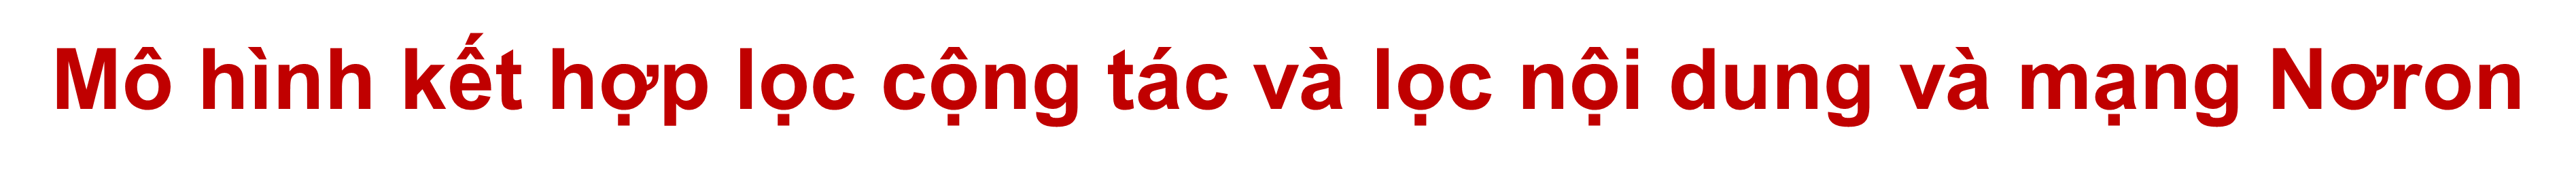
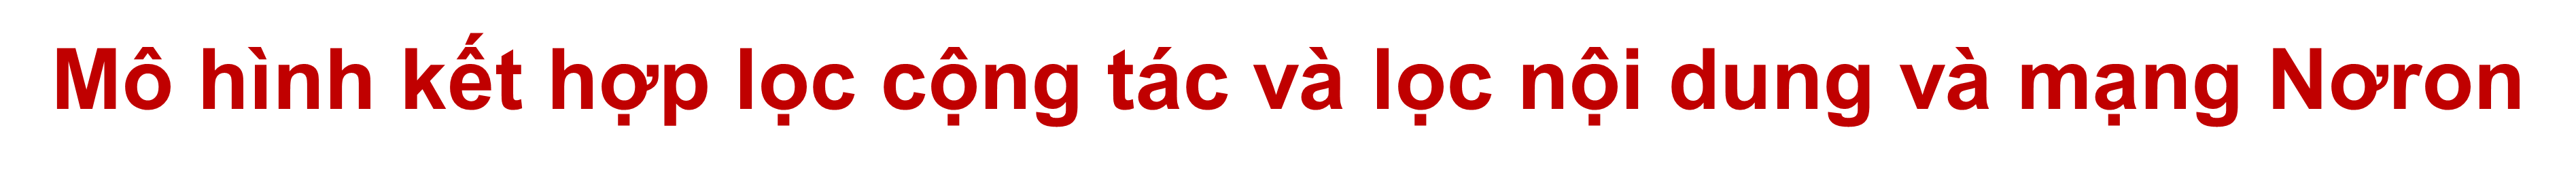
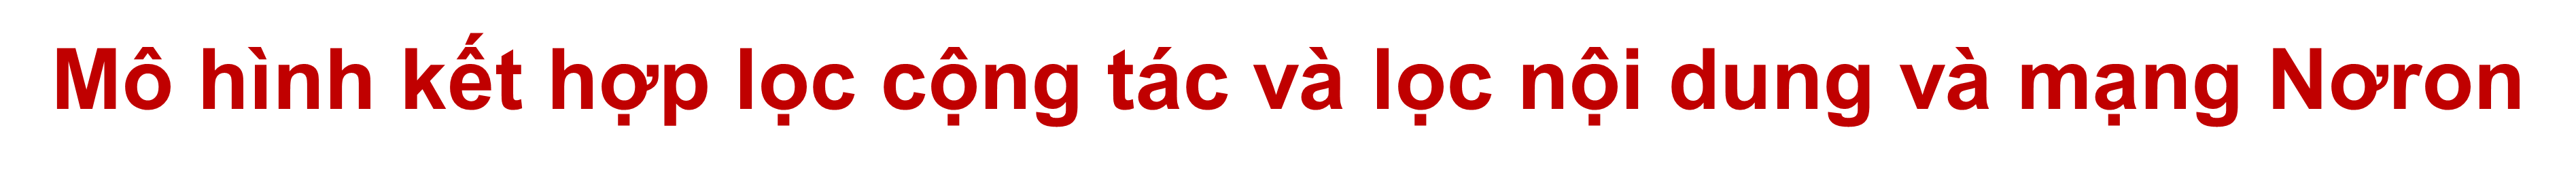
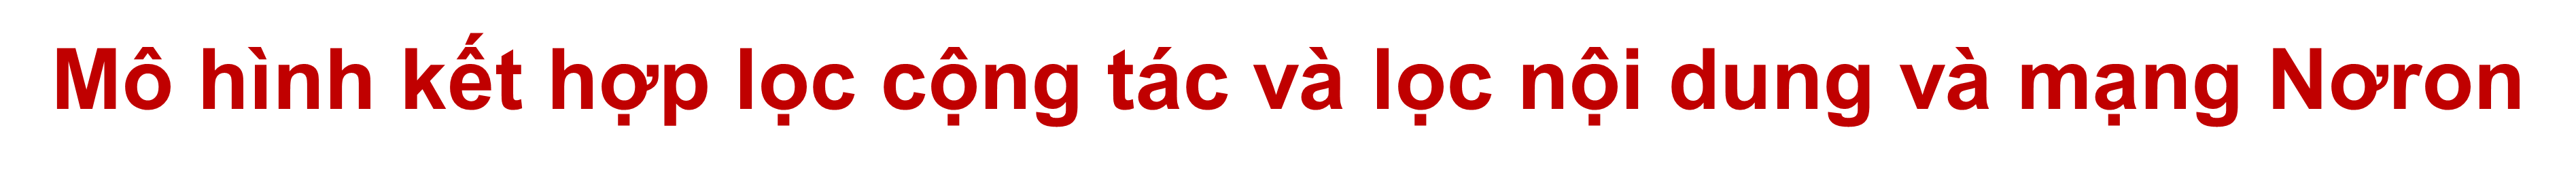

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ---- sanity checks
need_vars = ["item_meta", "transactions", "sampled_tx", "popular_items", "popular_12", "ARTIFACT_DIR", "RANDOM_STATE", "device"]
for v in need_vars:
    if v not in globals():
        raise NameError(f"Missing required variable: {v}")

# =========================
# 1) Train/Load FastText
# =========================
from gensim.models import FastText

FT_DIM = 64
FT_EPOCHS = 10
ft_path = Path(ARTIFACT_DIR) / f"fasttext_dim{FT_DIM}.model"

ft_df = item_meta[["article_id","detail_desc"]].copy()
ft_df["detail_desc"] = ft_df["detail_desc"].fillna("").astype(str).str.lower()

sentences = [s.split() for s in ft_df["detail_desc"].values if s.strip()]
print("FastText sentences:", len(sentences))

if ft_path.exists():
    ft_model = FastText.load(str(ft_path))
    print("Loaded:", ft_path)
else:
    ft_model = FastText(
        vector_size=FT_DIM,
        window=5,
        min_count=2,
        workers=4,
        sg=1,
        seed=RANDOM_STATE
    )
    ft_model.build_vocab(corpus_iterable=sentences)
    ft_model.train(corpus_iterable=sentences, total_examples=len(sentences), epochs=FT_EPOCHS)
    ft_model.save(str(ft_path))
    print("Saved:", ft_path)

def ft_vec(text: str) -> np.ndarray:
    toks = str(text).lower().split()
    vecs = [ft_model.wv[w] for w in toks if w in ft_model.wv]
    if not vecs:
        return np.zeros(FT_DIM, dtype=np.float32)
    return np.mean(vecs, axis=0).astype(np.float32)

# =========================
# 2) Item universe + (text vec, price)
# =========================
price_df = transactions.groupby("article_id")["price"].mean()
item_price_map = price_df.to_dict()

NN_MAX_ITEMS = 60000
if "item_pop_series" in globals():
    nn_item_ids = item_pop_series.index.astype(int).tolist()[:NN_MAX_ITEMS]
else:
    nn_item_ids = item_meta["article_id"].astype(int).tolist()[:NN_MAX_ITEMS]

nn_item_ids = np.array(sorted(set(map(int, nn_item_ids))), dtype=np.int32)
aid2i = {int(a): i for i, a in enumerate(nn_item_ids)}
i2aid = {i: int(a) for i, a in enumerate(nn_item_ids)}

tmp_meta = item_meta[item_meta["article_id"].astype(int).isin(nn_item_ids)][["article_id","detail_desc"]].copy()
tmp_meta["detail_desc"] = tmp_meta["detail_desc"].fillna("").astype(str)

item_text_mat = np.zeros((len(nn_item_ids), FT_DIM), dtype=np.float32)
item_price_vec = np.zeros((len(nn_item_ids), 1), dtype=np.float32)

# (nhanh hơn iterrows: dùng values)
aids = tmp_meta["article_id"].astype(int).values
descs = tmp_meta["detail_desc"].values

for a, desc in tqdm(zip(aids, descs), total=len(aids), desc="item ft vec"):
    idx = aid2i.get(int(a))
    if idx is None:
        continue
    item_text_mat[idx] = ft_vec(desc)
    item_price_vec[idx, 0] = float(item_price_map.get(int(a), 0.0))

# normalize text vectors
norm = np.linalg.norm(item_text_mat, axis=1, keepdims=True) + 1e-9
item_text_mat = item_text_mat / norm

# =========================
# 3) Build training pairs (pos + neg)
# =========================
pos_df = sampled_tx[["customer_id","article_id"]].drop_duplicates().copy()
pos_df["customer_id"] = pos_df["customer_id"].astype(str)
pos_df["article_id"]  = pos_df["article_id"].astype(int)
pos_df = pos_df[pos_df["article_id"].isin(aid2i)]
print("NN positives:", len(pos_df))

nn_user_ids = pos_df["customer_id"].unique()
uid2u = {u:i for i, u in enumerate(nn_user_ids)}

user_bought = pos_df.groupby("customer_id")["article_id"].apply(set).to_dict()
popular_pool = [int(a) for a in popular_items[:5000] if int(a) in aid2i]
if len(popular_pool) == 0:
    raise RuntimeError("popular_pool is empty (no overlap with aid2i). Reduce filters or increase NN_MAX_ITEMS.")

NEG_PER_POS = 2
rng = np.random.default_rng(RANDOM_STATE)

pairs_u, pairs_i, labels = [], [], []

for cid, grp in tqdm(pos_df.groupby("customer_id"), desc="build pairs"):
    u = uid2u[cid]
    bought = user_bought.get(cid, set())
    pos_items = grp["article_id"].tolist()

    for a in pos_items:
        a = int(a)
        pairs_u.append(u)
        pairs_i.append(aid2i[a])
        labels.append(1.0)

        # negatives
        for _ in range(NEG_PER_POS):
            for _try in range(20):
                neg_a = int(rng.choice(popular_pool))
                if neg_a not in bought:
                    pairs_u.append(u)
                    pairs_i.append(aid2i[neg_a])
                    labels.append(0.0)
                    break

pairs_u = np.array(pairs_u, dtype=np.int64)
pairs_i = np.array(pairs_i, dtype=np.int64)
labels  = np.array(labels, dtype=np.float32)

print("Train pairs:", len(labels), "pos:", int(labels.sum()), "neg:", int((labels==0).sum()))

# =========================
# 4) Dataset / Model
# =========================
class PairDS(Dataset):
    def __init__(self, u_idx, i_idx, y, text_mat, price_vec):
        self.u = torch.from_numpy(u_idx).long()
        self.i = torch.from_numpy(i_idx).long()
        self.y = torch.from_numpy(y).float()
        self.text_mat = torch.from_numpy(text_mat).float()   # [n_items, FT_DIM]
        self.price_vec = torch.from_numpy(price_vec).float() # [n_items, 1]

    def __len__(self): 
        return len(self.y)

    def __getitem__(self, k):
        i = int(self.i[k])
        return (
            self.u[k],
            self.i[k],
            self.text_mat[i],
            self.price_vec[i],
            self.y[k],
        )

class FastTextNN(nn.Module):
    def __init__(self, n_users, n_items, ft_dim, emb_dim=64, hidden=256, drop=0.2):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, emb_dim)
        self.item_emb = nn.Embedding(n_items, emb_dim)
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim + emb_dim + ft_dim + 1, hidden),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(hidden, 1)
        )

    def forward(self, u, i, ft_vec, price):
        ue = self.user_emb(u)
        ie = self.item_emb(i)
        x = torch.cat([ue, ie, ft_vec, price], dim=1)
        return self.mlp(x).squeeze(1)

ds = PairDS(pairs_u, pairs_i, labels, item_text_mat, item_price_vec)
dl = DataLoader(
    ds,
    batch_size=4096,
    shuffle=True,
    num_workers=2,
    pin_memory=(device.type == "cuda")
)

model_ftnn = FastTextNN(n_users=len(nn_user_ids), n_items=len(nn_item_ids), ft_dim=FT_DIM).to(device)
opt = torch.optim.Adam(model_ftnn.parameters(), lr=1e-3)
crit = nn.BCEWithLogitsLoss()

use_amp = (device.type == "cuda")
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

EPOCHS_NN = 10
model_ftnn.train()
for ep in range(EPOCHS_NN):
    tot = 0.0
    for u, i, ftv, p, y in tqdm(dl, desc=f"FTNN epoch {ep+1}/{EPOCHS_NN}"):
        # ---- FIX: gán biến đúng (không dùng u=i_u=...)
        u = u.to(device, non_blocking=True)
        i = i.to(device, non_blocking=True)
        ftv = ftv.to(device, non_blocking=True)
        p = p.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=use_amp):
            logit = model_ftnn(u, i, ftv, p)
            loss = crit(logit, y)

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        tot += float(loss.item()) * len(y)

    print("epoch", ep+1, "loss", tot / len(ds))


In [ ]:
from pathlib import Path
import numpy as np
import torch

# ---- require
need_vars = ["sample_customer_ids", "true_items_dict", "popular_12", "popular_items", "aid2i", "item_text_mat", "item_price_vec", "model_ftnn", "uid2u"]
for v in need_vars:
    if v not in globals():
        raise NameError(f"Missing required variable: {v}")

# ---- nếu thiếu train_hist/train_bought_set thì build nhanh từ train_df (nếu có)
if "train_hist" not in globals() or "train_bought_set" not in globals():
    if "train_df" not in globals():
        raise NameError("Missing train_hist/train_bought_set and train_df not found to rebuild.")
    _td = train_df.copy()
    _td["customer_id"] = _td["customer_id"].astype(str)
    _td["article_id"] = _td["article_id"].astype(int)
    _td = _td.sort_values(["customer_id", "t_dat"])
    train_hist = _td.groupby("customer_id")["article_id"].apply(list).to_dict()
    train_bought_set = _td.groupby("customer_id")["article_id"].apply(lambda s: set(map(int, s.values))).to_dict()
    print("[INFO] rebuilt train_hist/train_bought_set from train_df")

@torch.no_grad()
def ftnn_score_user_on_candidates(cid, cand_aids, batch=4096):
    cid = str(cid)
    if cid not in uid2u:
        return None, None

    u = uid2u[cid]
    # map aids -> indices
    ii = [aid2i[int(a)] for a in cand_aids if int(a) in aid2i]
    if len(ii) == 0:
        return None, None

    model_ftnn.eval()
    scores = []

    # batch scoring (nhanh + đỡ OOM)
    for s in range(0, len(ii), batch):
        jj = ii[s:s+batch]
        u_t = torch.full((len(jj),), u, dtype=torch.long, device=device)
        i_t = torch.tensor(jj, dtype=torch.long, device=device)
        ftv = torch.from_numpy(item_text_mat[jj]).float().to(device)
        pv  = torch.from_numpy(item_price_vec[jj]).float().to(device)

        logit = model_ftnn(u_t, i_t, ftv, pv)
        sc = torch.sigmoid(logit).detach().cpu().numpy()
        scores.append(sc)

    scores = np.concatenate(scores, axis=0)
    return scores, ii

def build_candidates(cid, n_pop=200, n_cf=100, n_cb=100):
    cid = str(cid)
    cands = []
    cands += popular_items[:n_pop]
    if "recommend_cf_svd" in globals():
        cands += recommend_cf_svd(cid)[:n_cf]
    if "recommend_content_based" in globals():
        cands += recommend_content_based(cid)[:n_cb]
    return uniq_keep_order([int(x) for x in cands if int(x) in aid2i])

def recommend_ftnn(cid, topk=12):
    cid = str(cid)
    bought = train_bought_set.get(cid, set())

    cands = [a for a in build_candidates(cid) if a not in bought]
    if len(cands) == 0:
        return popular_12

    score, _ = ftnn_score_user_on_candidates(cid, cands)
    if score is None:
        return popular_12

    order = np.argsort(-score)
    recs = [int(cands[i]) for i in order[:topk]]
    return recs if recs else popular_12

def rec_ftnn(cid):
    return recommend_ftnn(str(cid), topk=12)

# -------------------------
# Submission (SAMPLE ONLY)
# -------------------------
OUT_FTNN = Path("/kaggle/working/submission_fasttext_nn_SAMPLE.csv")
WRITE_LIMIT = None  # None để submit thật; 1000 để test nhanh

write_submission_stream(
    sample_customer_ids,
    rec_ftnn,
    fallback_12=popular_12,
    out_csv=OUT_FTNN,
    max_customers=WRITE_LIMIT
)
print("Saved:", OUT_FTNN)

# -------------------------
# Full metrics @12
# (cần có eval_metrics_at_12 từ phần trước bạn dùng cho Popularity)
# -------------------------
if "eval_metrics_at_12" not in globals():
    raise NameError("eval_metrics_at_12 is not defined. Paste the metrics cell (MAP/Precision/Recall/F1/Acc/Hit) first.")

MAX_EVAL_USERS = 20000  # None = full sample
metrics_ftnn = eval_metrics_at_12(sample_customer_ids, true_items_dict, rec_ftnn, max_users=MAX_EVAL_USERS)

print("\nFastTextNN metrics (internal, sample customers):")
for k, v in metrics_ftnn.items():
    print(f"  {k}: {v}")